# Waveform Generation and Analysis with Custom Time Steps

This notebook builds upon the foundation of the `wave_sampling_window_v4` notebook, introducing enhanced flexibility in waveform generation and analysis by allowing custom time steps for each selected waveform.

## Key Features:
- **Custom Time Steps**: Users can define individual time steps for different waveforms, enabling finer control over the waveform's resolution and the number of samples.
- **Waveform Generation**: The notebook supports the generation of various waveforms including sine waves, amplitude-modulated waves, frequency-modulated waves, and their combinations.
- **Windowing**: An option to apply different windowing techniques to the waveforms. This helps in reducing spectral leakage during frequency domain analysis.
- **DFT Analysis**: Each waveform undergoes Discrete Fourier Transform (DFT) analysis, providing insights into its frequency spectrum in terms of magnitude and phase.
- **Audio Rendering**: The generated waveforms can be saved as audio files. The audio rendering process involves resampling to a common sample rate (e.g., 44.1kHz) while preserving the original pitch and duration. 
- **Visualization**: The notebook uses Plotly for visualization, offering interactive plots for both time-domain waveforms and frequency-domain spectra.

## Usage:
1. Define waveform parameters such as amplitude, frequency, and phase.
2. Choose the desired waveforms from options like 'sine1', 'sine2', 'am', 'fm', 'sum', and 'comb'.
3. Specify custom time steps for each selected waveform.
4. Optionally apply windowing functions to the waveforms.
5. Visualize the generated waveforms in the time domain.
6. Analyze the frequency content of the waveforms through DFT magnitude and phase plots.
7. Render and listen to the waveforms as audio files.

**Note**: This enhanced capability of defining custom time steps allows users to experiment with varying resolutions and observe the effects on waveform generation, DFT analysis, and audio rendering.


Waveform: sine1
Sampling rate: 1000.0 Hz
Nyquist frequency: 500.0 Hz
Total number of available sample points: 2000
Frequency Resolution: 0.5 Hz
------------------------------
Waveform: sine2
Sampling rate: 200.0 Hz
Nyquist frequency: 100.0 Hz
Total number of available sample points: 400
Frequency Resolution: 0.5 Hz
------------------------------


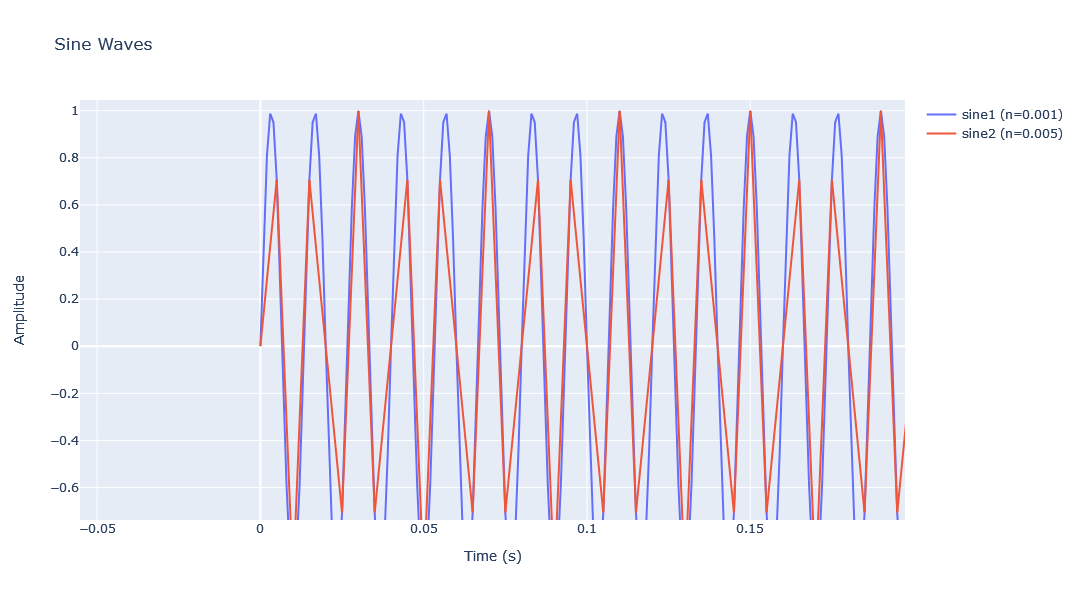

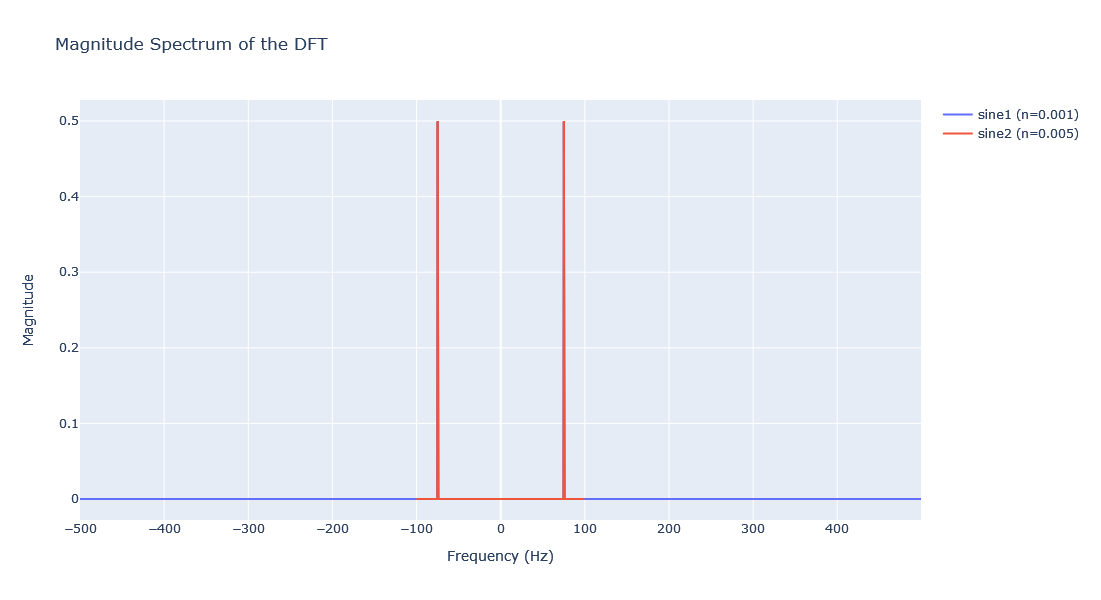

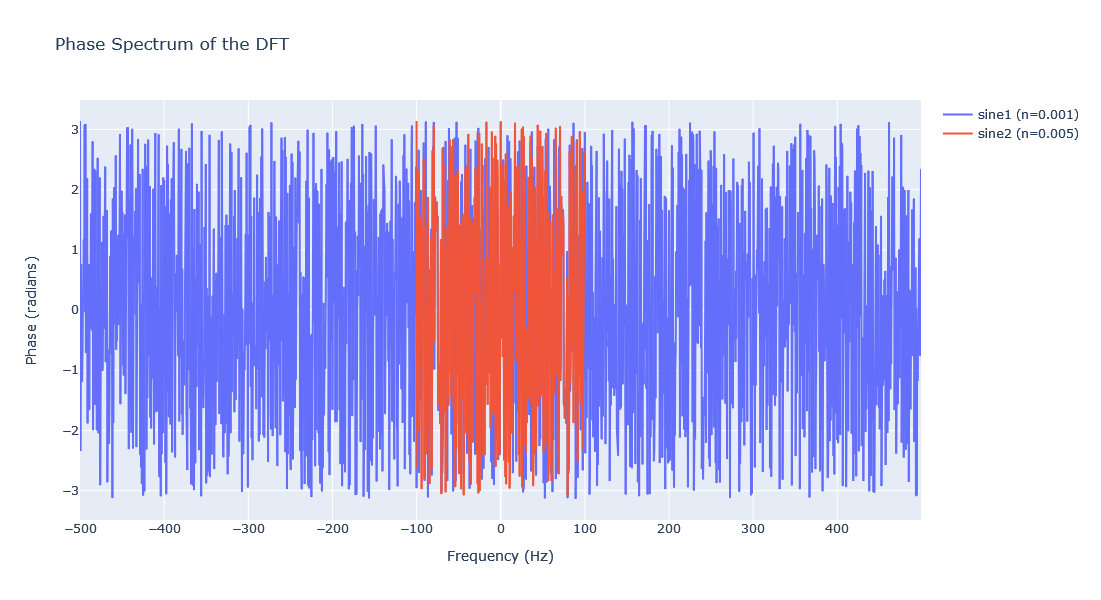

In [38]:
import numpy as np
import plotly.graph_objects as go
from scipy.signal import get_window

# Define all parameters
time_steps = {'comb': 0.005, 'sine1': 0.001, 'sine2': 0.005, 'am': 0.005, 'fm': 0.005, 'sum': 0.005}
t_max = 2.0
selected_waveforms = ['sine1', 'sine2']

amp1, freq1, phase1 = 1.0, 75, 0*np.pi/2
amp2, freq2, phase2 = 1.0, 75, 0*np.pi/2

index_am = 1
index_fm = 0.1

apply_window = False
window_type = 'blackman'

fig_waveforms = go.Figure()
fig_dft_magnitude = go.Figure()
fig_dft_phase = go.Figure()
max_dft_amp = 0
min_dft_phase = np.inf

for waveform in selected_waveforms:
    n = time_steps[waveform]
    t = np.arange(0, t_max, n)
    num_samples = len(t)

    waveform_data = {}

    waveform_data['sine1'] = amp1 * np.sin(2*np.pi*freq1*t + phase1)
    waveform_data['sine2'] = amp2 * np.sin(2*np.pi*freq2*t + phase2)
    waveform_data['am'] = (amp1 + index_am * waveform_data['sine2']) * np.sin(2*np.pi*freq1*t + phase1)
    waveform_data['fm'] = amp1 * np.sin(2*np.pi*(freq1 + index_fm * waveform_data['sine2'])*t + phase1)
    waveform_data['sum'] = waveform_data['sine1'] + waveform_data['sine2']

    waveform_data['comb'] = np.zeros_like(t)
    half_period = int(t_max / (2 * n))

    for i in range(0, len(t), half_period):
        if (i // half_period) % 2 == 0:
            waveform_data['comb'][i:i+half_period] = waveform_data['sine1'][i:i+half_period]
        else:
            waveform_data['comb'][i:i+half_period] = waveform_data['sine2'][i:i+half_period]

 
    # Calculate and print sampling rate, Nyquist frequency, and total sample points for each waveform
    sampling_rate = 1 / n
    nyquist_freq = sampling_rate / 2
    total_points = len(t)
    freq_resolution = sampling_rate / total_points
    print(f"Waveform: {waveform}")
    print(f"Sampling rate: {sampling_rate} Hz")
    print(f"Nyquist frequency: {nyquist_freq} Hz")
    print(f"Total number of available sample points: {total_points}")
    print(f"Frequency Resolution: {freq_resolution} Hz")
    print("-" * 30)

    # DFT Magnitude and Phase Plots
    y = waveform_data[waveform]
    Y = np.fft.fft(y) / num_samples  # Normalizing by the number of samples
    freqs = np.fft.fftfreq(num_samples, d=n)
    inds = np.argsort(freqs)
    freqs = freqs[inds]
    Y = Y[inds]

    fig_dft_magnitude.add_trace(go.Scatter(x=freqs, y=np.abs(Y), mode='lines', name=f"{waveform} (n={n})" + (' - ' + window_type if apply_window else "")))
    fig_dft_phase.add_trace(go.Scatter(x=freqs, y=np.angle(Y), mode='lines', name=f"{waveform} (n={n})" + (' - ' + window_type if apply_window else "")))
    fig_waveforms.add_trace(go.Scatter(x=t, y=waveform_data[waveform], mode='lines', name=f"{waveform} (n={n})"))

fig_waveforms.update_layout(title='Sine Waves', xaxis_title='Time (s)', yaxis_title='Amplitude',
                            autosize=False, width=800, height=600)
fig_waveforms.show()

fig_dft_magnitude.update_layout(title='Magnitude Spectrum of the DFT', xaxis_title='Frequency (Hz)', yaxis_title='Magnitude',
                            autosize=False, width=800, height=600)
fig_dft_magnitude.show()

fig_dft_phase.update_layout(title='Phase Spectrum of the DFT', xaxis_title='Frequency (Hz)', yaxis_title='Phase (radians)',
                            autosize=False, width=800, height=600)
fig_dft_phase.show()


In [39]:
import numpy as np
from generate_wave_file import generate_wave_file
from IPython.display import Audio
from datetime import datetime
from scipy.signal import resample

# Flags to control behavior
player = True
save_audio = True

# Determine the exact number of samples for the waveform with the smallest n (highest sample rate)
num_samples_common_sr = int(t_max / min(time_steps.values()))

for waveform in selected_waveforms:
    # Extract sample rate for the current waveform
    n = time_steps[waveform]
    sample_rate = 1 / n

    # Extract data for the current waveform
    y_current = waveform_data[waveform]
    
    # Resample the waveform to the exact number of samples
    y_resampled_to_common_sr = resample(y_current, num_samples_common_sr)
    
    # Now, generate the audio file using this resampled waveform
    custom_name = f"{waveform}_{sample_rate}Hz_{datetime.now().strftime('%H_%M_%S')}.wav"
    file_path = generate_wave_file(y_resampled_to_common_sr, 1/(t_max/num_samples_common_sr), fs_target_name='44.1kHz', bit_rate=24, custom_filename=custom_name)
    
    if player:
        print(f"Playing waveform: {waveform} with n = {n}")
        audio = Audio(filename=file_path)
        display(audio)


[2023-09-17 13:20:32] 24-bit wave file with 44.1kHz sampling rate saved successfully to: C:\Users\egor_\Desktop\tests\audiospylt\rendered_audio\sine1_1000.0Hz_13_20_32.wav
Playing waveform: sine1 with n = 0.001


[2023-09-17 13:20:32] 24-bit wave file with 44.1kHz sampling rate saved successfully to: C:\Users\egor_\Desktop\tests\audiospylt\rendered_audio\sine2_200.0Hz_13_20_32.wav
Playing waveform: sine2 with n = 0.005
